# Training curve of the GBT model

In this notebook, we analyze the impact of the training set size on the training and test set performance of our best algorithm implemented on Spark (a gradient boosted tree with tuned hyperparameters).

In [1]:
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


## Input data parsing

In [2]:
inputPath = "/user/s291516/preprocessed/"
trainData = spark.read.format("csv").option("header", True).option("inferSchema", True).load(inputPath + "trainData/").cache()
testData = spark.read.format("csv").option("header", True).option("inferSchema", True).load(inputPath + "testData/").cache()

## Evaluators definition

In [3]:
rmseEvaluator = RegressionEvaluator(predictionCol="prediction", labelCol="NumBikes+1", metricName="rmse")
r2Evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="NumBikes+1", metricName="r2")
resultsDF = pd.DataFrame(columns=["Fraction", "Metric", "Train", "Test"])

## Label mapper definition

In [4]:
class LabelMapper(Transformer):
    def _transform(self, inputDF):
        return inputDF.withColumn("prediction", F.col("prediction") + F.col("NumBikes"))

## Pipeline definition

In [5]:
pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=[
        "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
        "Hour", "DayOfWeek", "Zone",
        "AvgByHour", "AvgByWeekday", "AvgByZone", "AvgCombined"
    ], outputCol="features"),
    GBTRegressor(labelCol="NumBikesDiff+1", seed=42, maxDepth=5, maxIter=50, minInstancesPerNode=10, stepSize=0.25),
    LabelMapper()
])

## Folding

To analyze the impact of the training set size on the training and test set performance of the algorithm, we first split our training dataset in 10 non-overlapping folds; this is achieved by assigning each training record to a random number between 0 and 9. The (approximately equal) number of records assigned to each fold is reported as the output of this cell.

In [6]:
numFolds = 10
trainData = trainData.withColumn("Fold", F.floor(F.rand(seed=42) * numFolds))
trainData.groupBy("Fold").count().orderBy("Fold").show()

+----+------+
|Fold| count|
+----+------+
|   0|230792|
|   1|229718|
|   2|229880|
|   3|230765|
|   4|229868|
|   5|229098|
|   6|230369|
|   7|230405|
|   8|229676|
|   9|229785|
+----+------+



## Performance measurements

After folding, here we train 10 models, using at each iteration $i$ the first $i$ training folds as input. Once a model is trained, we use it to transform both the training sample and the full test set to compute the metrics of interest, which are also reported as output.

In [7]:
for i in range(numFolds):
    # Create the train sample by selecting the first i folds
    trainSample = trainData.filter(F.col("Fold") <= i)
    
    # Fit the pipeline on the train sample
    model = pipeline.fit(trainSample)
    
    # Evaluate on the training and test sets
    trainRMSE = rmseEvaluator.evaluate(model.transform(trainSample))
    trainR2 = r2Evaluator.evaluate(model.transform(trainSample))
    testRMSE = rmseEvaluator.evaluate(model.transform(testData))
    testR2 = r2Evaluator.evaluate(model.transform(testData))
    resultsDF = resultsDF.append([
        {"Fraction": (i + 1) / numFolds, "Metric": "RMSE", "Train": trainRMSE, "Test": testRMSE},
        {"Fraction": (i + 1) / numFolds, "Metric": "R2", "Train": trainR2, "Test": testR2}
    ], ignore_index=True)
    
    print(f"Completed iteration #{i + 1} (RMSE train: {trainRMSE}, R2 train: {trainR2}, RMSE test: {testRMSE}, R2 test: {testR2}).")

Completed iteration #1 (RMSE train: 1.4219504769838496, R2 train: 0.9621287227627202, RMSE test: 1.416493715971213, R2 test: 0.9675684341908405).
Completed iteration #2 (RMSE train: 1.4280731339923214, R2 train: 0.9618644428339801, RMSE test: 1.413753176612466, R2 test: 0.9676938057360542).
Completed iteration #3 (RMSE train: 1.4316784236831261, R2 train: 0.9616363054997069, RMSE test: 1.4127071234137567, R2 test: 0.967741595542806).
Completed iteration #4 (RMSE train: 1.4305384806964163, R2 train: 0.9616778856534496, RMSE test: 1.4116468566403926, R2 test: 0.9677899986109062).
Completed iteration #5 (RMSE train: 1.4337178556803314, R2 train: 0.9615212688479094, RMSE test: 1.4116471240139354, R2 test: 0.9677899864094084).
Completed iteration #6 (RMSE train: 1.4343390375893752, R2 train: 0.9615039004083412, RMSE test: 1.4113002048872583, R2 test: 0.9678058159981626).
Completed iteration #7 (RMSE train: 1.4352820112137008, R2 train: 0.9614561960517042, RMSE test: 1.4109010966569357, R2 t

Results are visualized in the following charts. We note how the training set metrics get worse (increased RMSE, decreased R2) for increasing training set size, while the test set metrics improve. Indeed, when we use a smaller training set, the model is able to better fit the fewer training records; however, the resulting model does not generalize properly on the test sets' unobserved records. Increasing the training size leads to decreased training set performance (it is harder to perfectly fit more data), but increased test set performance as the model is more robust.

For this algorithm, we also find that the test set metrics are actually always higher than the training set ones. This is certainly unusual, but not unexpected given the "uniformity" of our data and the size difference between training and test sets.

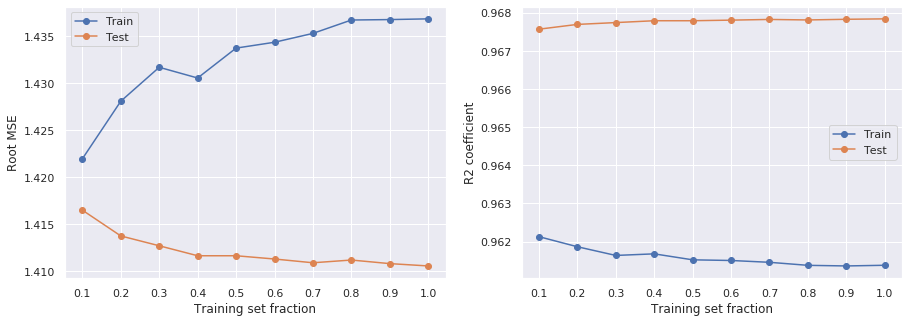

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
resultsDF[resultsDF["Metric"] == "RMSE"].plot(x="Fraction", y=["Train", "Test"], ax=ax[0], marker="o")
resultsDF[resultsDF["Metric"] == "R2"].plot(x="Fraction", y=["Train", "Test"], ax=ax[1], marker="o")
ax[0].set_xticks([(i + 1) / numFolds for i in range(numFolds)])
ax[1].set_xticks([(i + 1) / numFolds for i in range(numFolds)])
ax[0].set_xlabel("Training set fraction")
ax[1].set_xlabel("Training set fraction")
ax[0].set_ylabel("Root MSE")
ax[1].set_ylabel("R2 coefficient");